In [1]:
import segmentation_models as sm
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from fetch_data import fetch
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from visualise import visualize, denormalize

2023-02-16 15:25:13.058861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 15:25:13.273484: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-16 15:25:13.281311: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-16 15:25:13.281334: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

Segmentation Models: using `tf.keras` framework.


In [2]:
base_dir = '/media/dev/WinD/Curious Dev B/PROJECT STAGE - II/ISIC 2017 for segmentation (python) (test set only)/'
batch_size = 12
input_size = (224, 224)
num_epochs = 20
grp = 0
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

callbacks = [ModelCheckpoint('./testset_best_model.h5', 
                             monitor = "val_f1-score",
                             save_weights_only=True, 
                             save_best_only=True, 
                             mode='max',
                             initial_value_threshold = 0.5283),
            ReduceLROnPlateau(monitor = "val_f1-score",
                             factor = 0.2,
                             patience = 5,
                             verbose = 1,
                             mode = 'max')]

In [3]:
train_dataset, validation_dataset = fetch(base_dir, input_size, grp)

train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.shuffle(buffer_size=128)

validation_dataset = validation_dataset.batch(1)

2023-02-16 15:25:17.818230: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-16 15:25:17.818261: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-16 15:25:17.818281: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Turbo): /proc/driver/nvidia/version does not exist
2023-02-16 15:25:17.818624: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/dev/anaconda3/lib/python3.9/site-packages/tensorflow/python/dat

In [4]:
model = sm.Unet(backbone_name = "densenet121",
                   input_shape=(224, 224, 3))

model.compile(optimizer=Adam(learning_rate = 0.0001), 
              loss=sm.losses.bce_dice_loss, 
              metrics=metrics)

print(len(model.layers))
model.summary()

468
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                          

 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_blo

 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 28, 28, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization) 

 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_blo

 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 128)  40960       ['conv4_block3_0_relu[0][0]']    
          

 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block16_1_conv[0][0]']   
 lization)

 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 14, 14, 1024  4096        ['conv4_block24_concat[0][0]']   
                                )                                                                 
                                                                                                  
 pool4_relu (Activation)        (None, 14, 14, 1024  0           ['pool4_bn[0][0]']               
          

                                                                                                  
 conv5_block4_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block4_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block4_1_relu[0][0]']    
                                                                                                  
 conv5_block4_concat (Concatena  (None, 7, 7, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 7, 7, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization) 

 te)                                                              'conv5_block8_2_conv[0][0]']    
                                                                                                  
 conv5_block9_0_bn (BatchNormal  (None, 7, 7, 768)   3072        ['conv5_block8_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_0_relu (Activatio  (None, 7, 7, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 7, 7, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block13_1_conv (Conv2D)  (None, 7, 7, 128)    114688      ['conv5_block13_0_relu[0][0]']   
                                                                                                  
 conv5_block13_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block13_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block13_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block13_1_relu[0][0]']   
          

                                                                                                  
 decoder_stage0a_bn (BatchNorma  (None, 14, 14, 256)  1024       ['decoder_stage0a_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 decoder_stage0a_relu (Activati  (None, 14, 14, 256)  0          ['decoder_stage0a_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 decoder_stage0b_conv (Conv2D)  (None, 14, 14, 256)  589824      ['decoder_stage0a_relu[0][0]']   
                                                                                                  
 decoder_stage0b_bn (BatchNorma  (None, 14, 14, 256)  1024       ['decoder_stage0b_conv[0][0]']   
 lization)

 decoder_stage3b_relu (Activati  (None, 112, 112, 32  0          ['decoder_stage3b_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 decoder_stage4_upsampling (UpS  (None, 224, 224, 32  0          ['decoder_stage3b_relu[0][0]']   
 ampling2D)                     )                                                                 
                                                                                                  
 decoder_stage4a_conv (Conv2D)  (None, 224, 224, 16  4608        ['decoder_stage4_upsampling[0][0]
                                )                                ']                               
                                                                                                  
 decoder_stage4a_bn (BatchNorma  (None, 224, 224, 16  64         ['decoder_stage4a_conv[0][0]']   
 lization)

In [5]:
history = model.fit(train_dataset, epochs=num_epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/20
50/50 [==============================] - 660s 13s/step - loss: 1.1627 - iou_score: 0.4376 - f1-score: 0.5823 - val_loss: 1.3385 - val_iou_score: 0.3207 - val_f1-score: 0.4413 - lr: 1.0000e-04
Epoch 2/20
50/50 [==============================] - 783s 16s/step - loss: 0.8334 - iou_score: 0.6184 - f1-score: 0.7437 - val_loss: 1.3189 - val_iou_score: 0.3861 - val_f1-score: 0.5052 - lr: 1.0000e-04
Epoch 3/20
50/50 [==============================] - 702s 14s/step - loss: 0.6779 - iou_score: 0.6933 - f1-score: 0.7998 - val_loss: 0.9239 - val_iou_score: 0.5607 - val_f1-score: 0.6829 - lr: 1.0000e-04
Epoch 4/20
50/50 [==============================] - 785s 16s/step - loss: 0.5913 - iou_score: 0.7305 - f1-score: 0.8309 - val_loss: 0.8476 - val_iou_score: 0.5917 - val_f1-score: 0.6936 - lr: 1.0000e-04
Epoch 5/20
50/50 [==============================] - 649s 13s/step - loss: 0.5162 - iou_score: 0.7742 - f1-score: 0.8610 - val_loss: 0.7979 - val_iou_score: 0.5829 - val_f1-score: 0.6847 - 

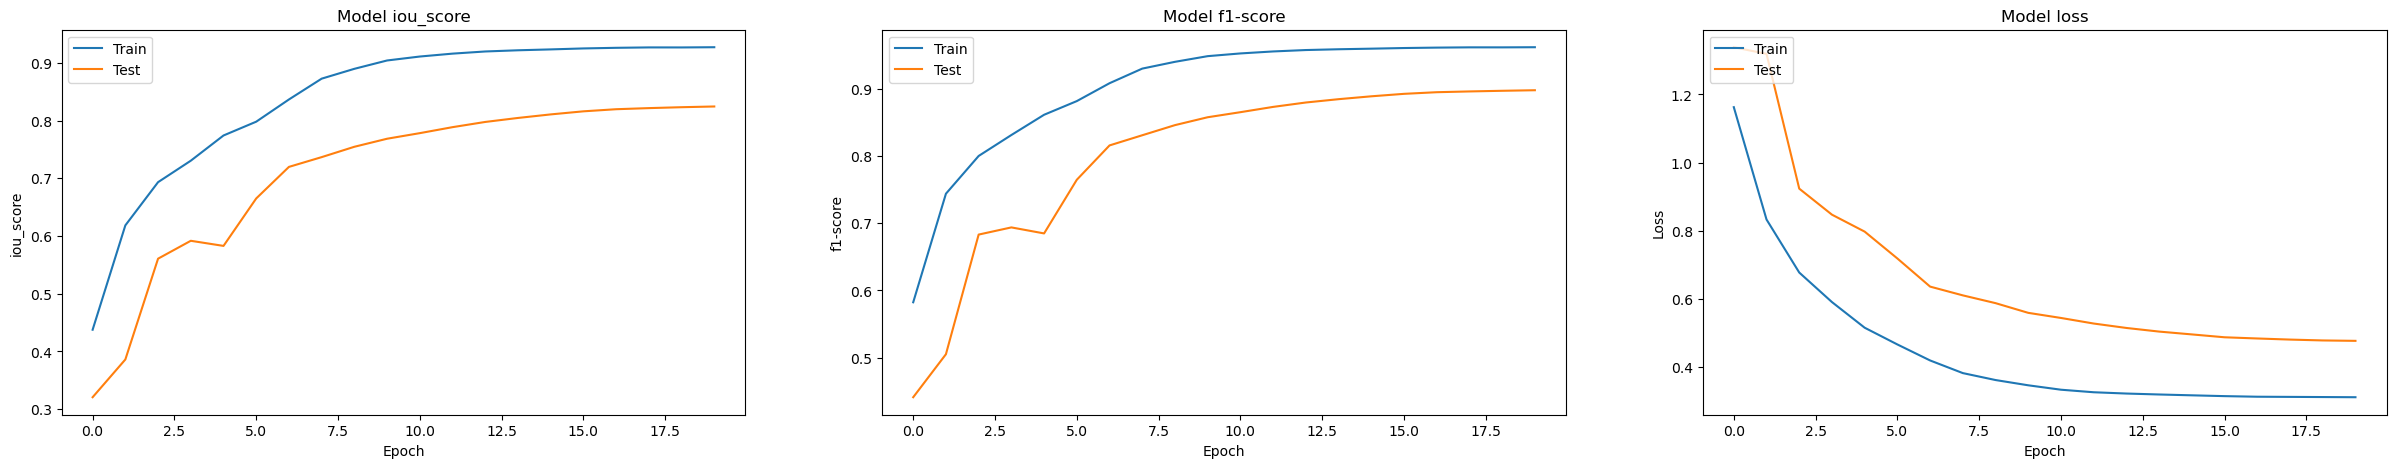

In [10]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(131)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation iou_score values
plt.subplot(132)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(133)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [7]:
model.load_weights('testset_best_model.h5') 

In [8]:
scores = model.evaluate(validation_dataset)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

600/600 [==============================] - 205s 342ms/step - loss: 1.3385 - iou_score: 0.3207 - f1-score: 0.4413
Loss: 1.3385
mean iou_score: 0.32068
mean f1-score: 0.44125


1/1 [==============================] - 0s 331ms/step


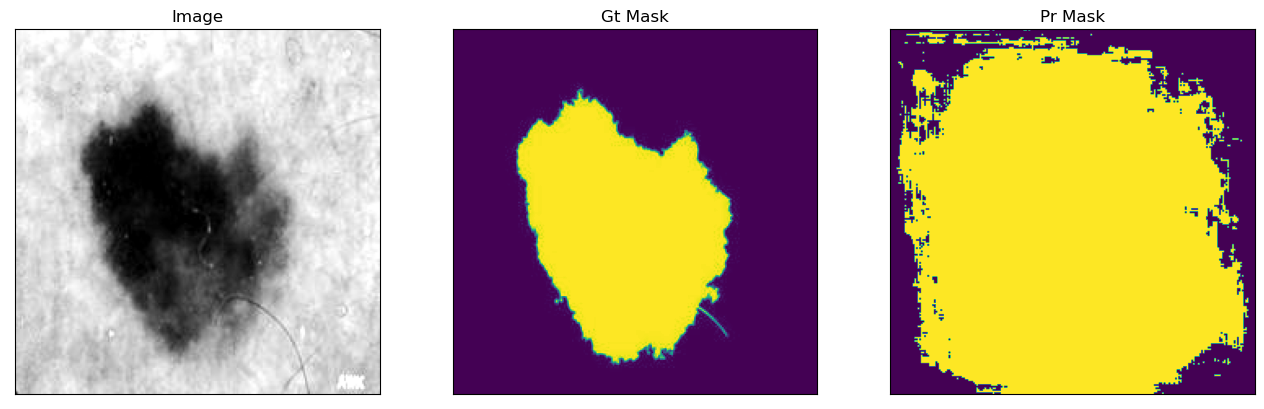

1/1 [==============================] - 0s 329ms/step


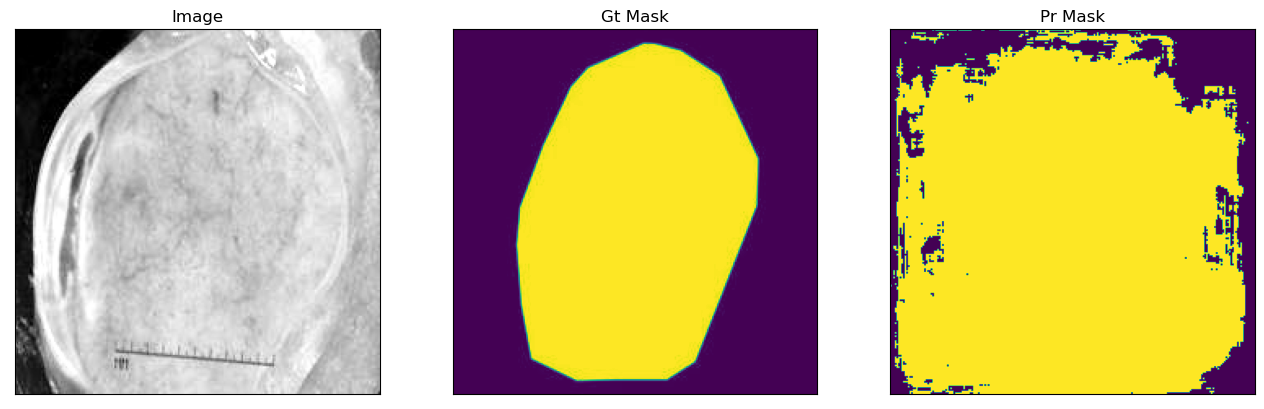

1/1 [==============================] - 0s 392ms/step


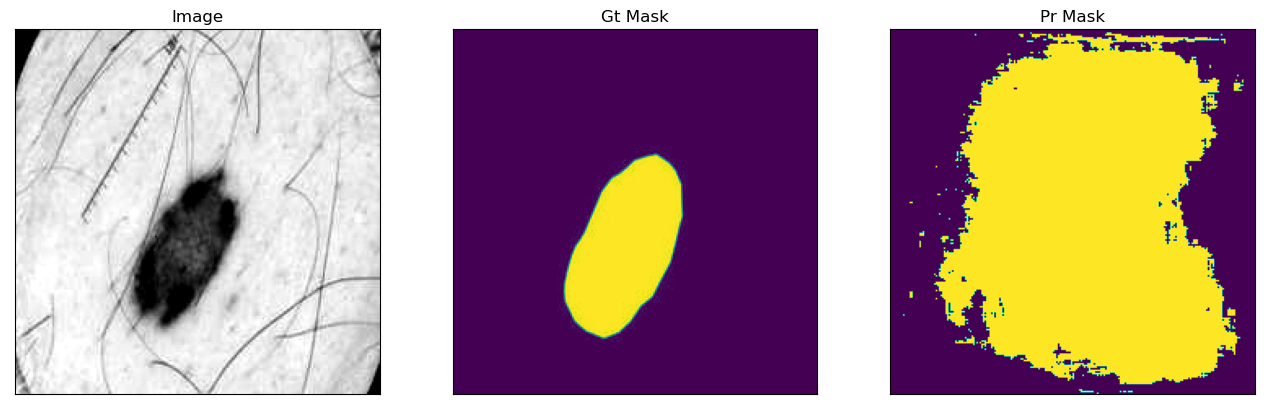

1/1 [==============================] - 0s 263ms/step


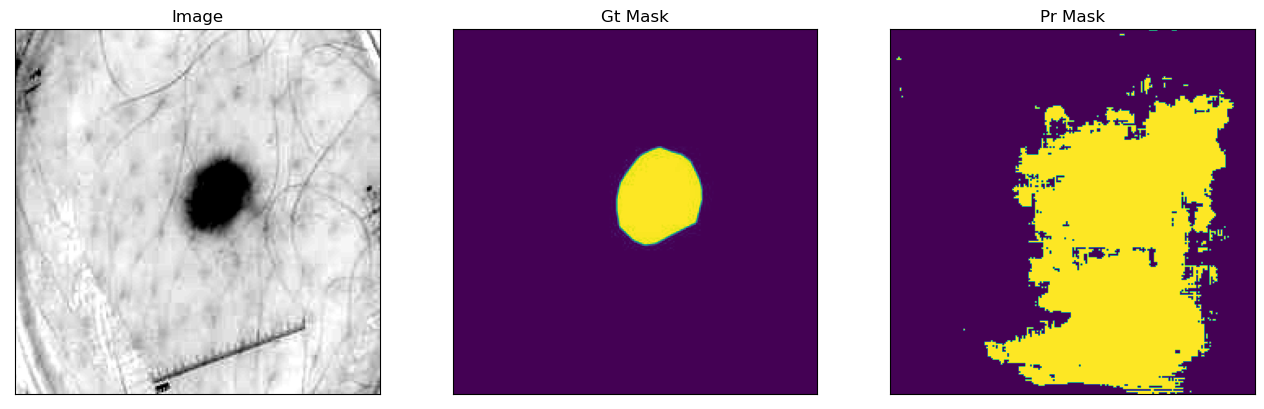

1/1 [==============================] - 0s 265ms/step


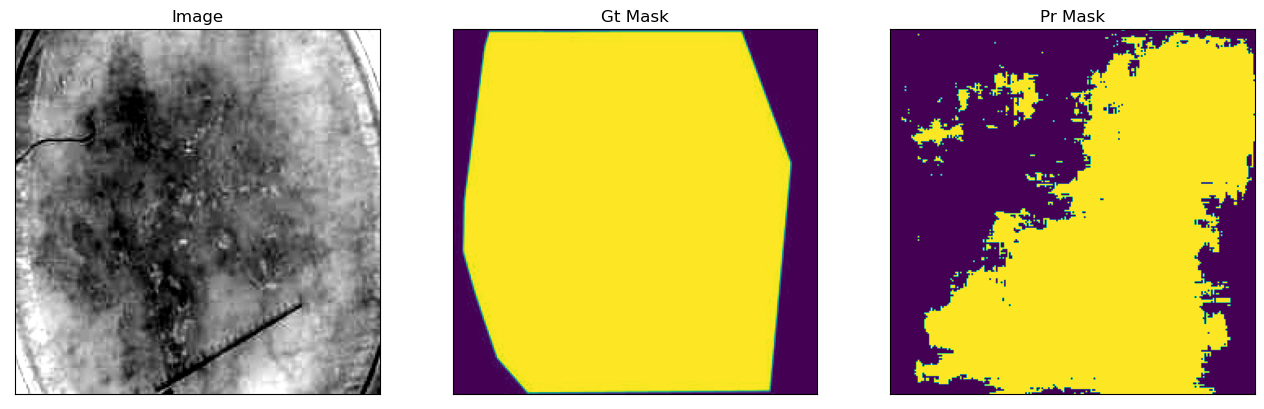

1/1 [==============================] - 0s 230ms/step


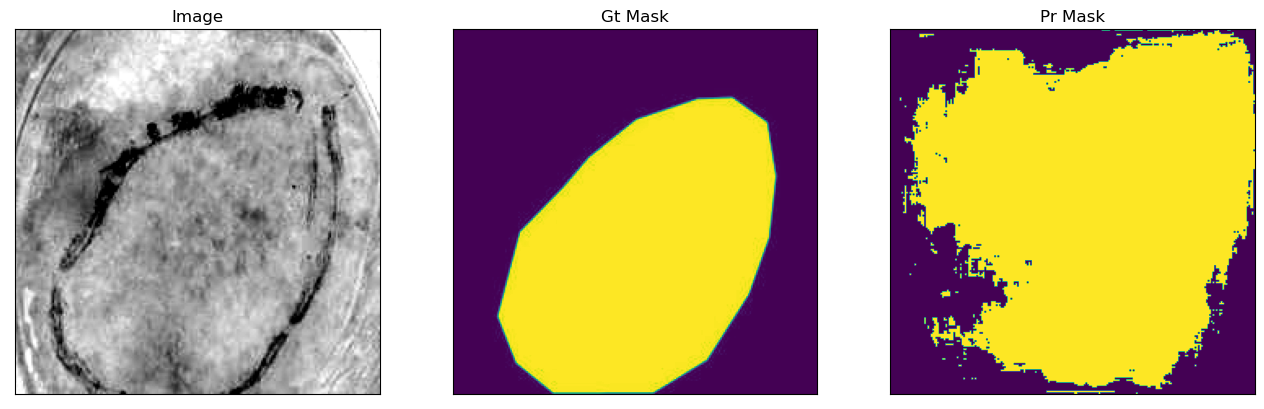

1/1 [==============================] - 0s 310ms/step


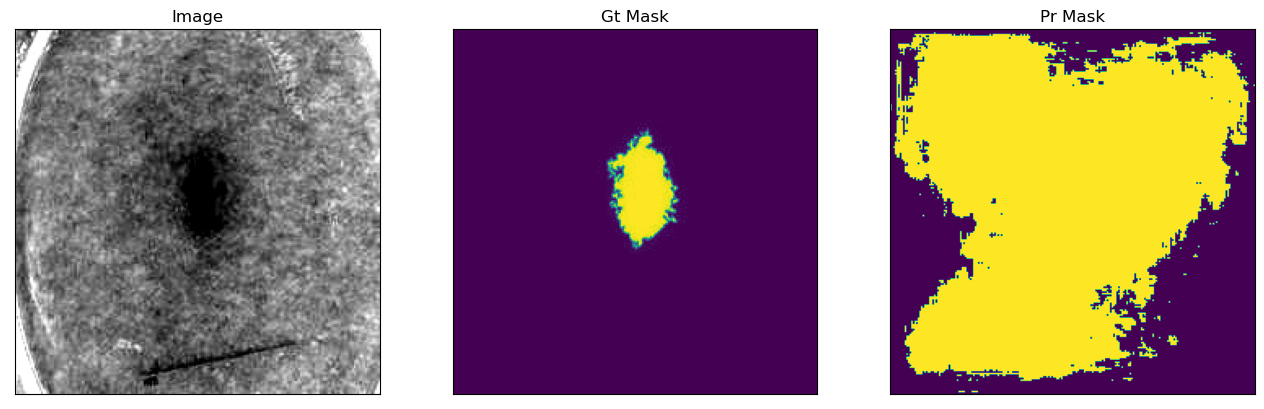

1/1 [==============================] - 1s 582ms/step


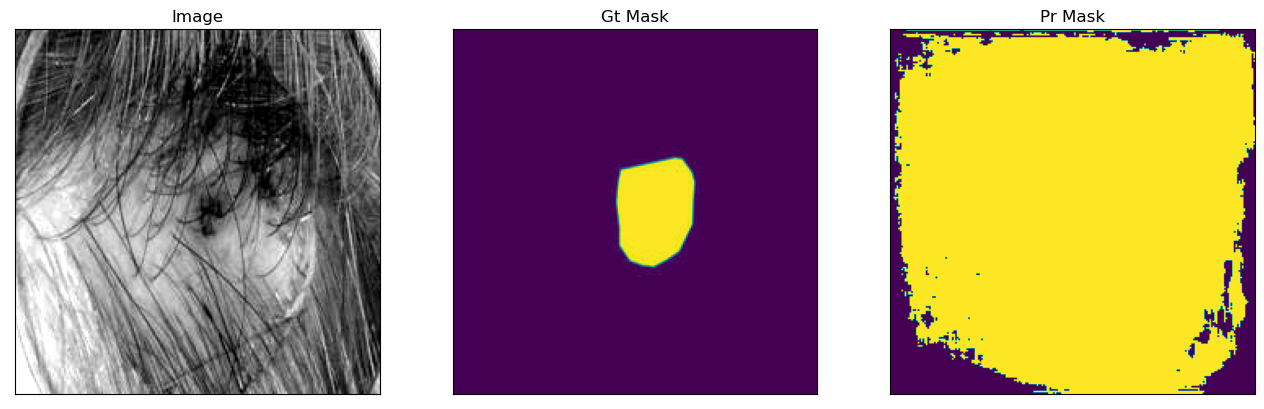

1/1 [==============================] - 0s 271ms/step


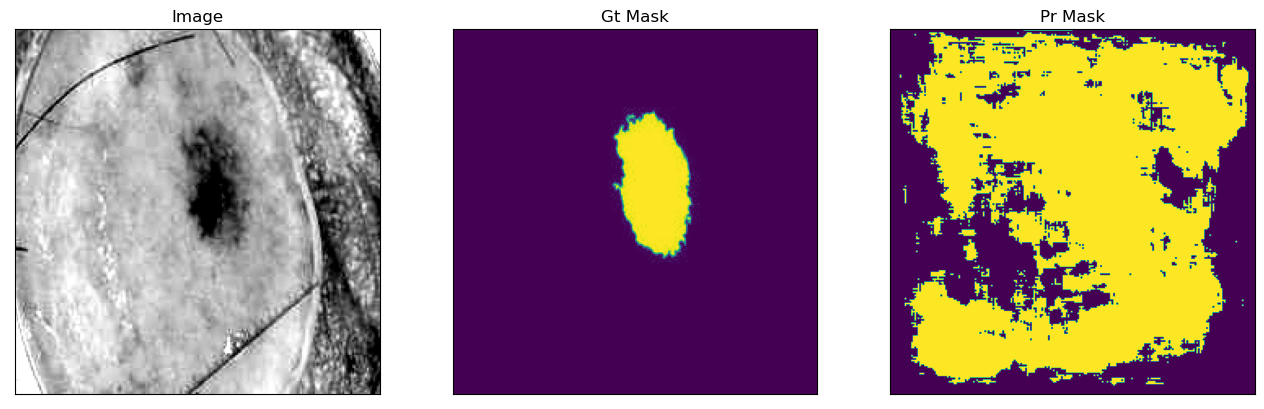

1/1 [==============================] - 0s 252ms/step


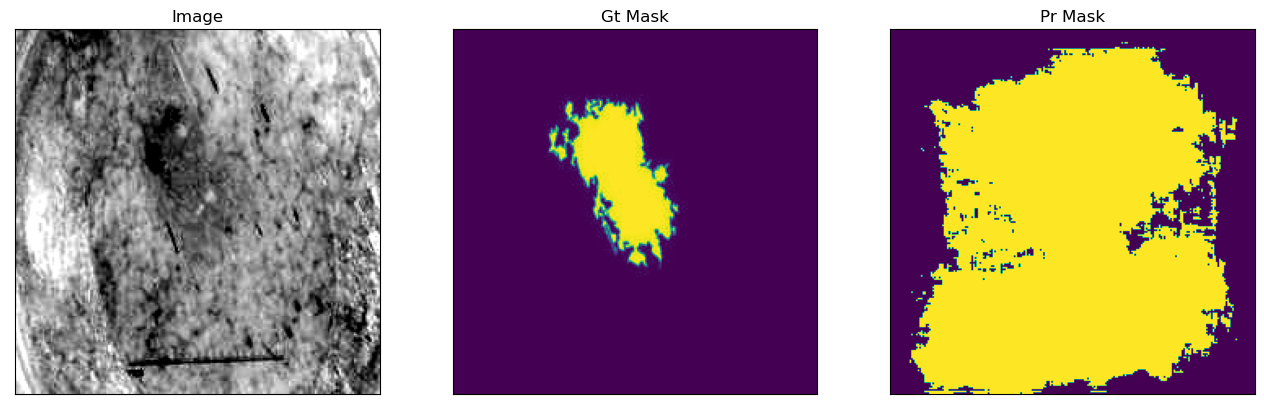

1/1 [==============================] - 0s 312ms/step


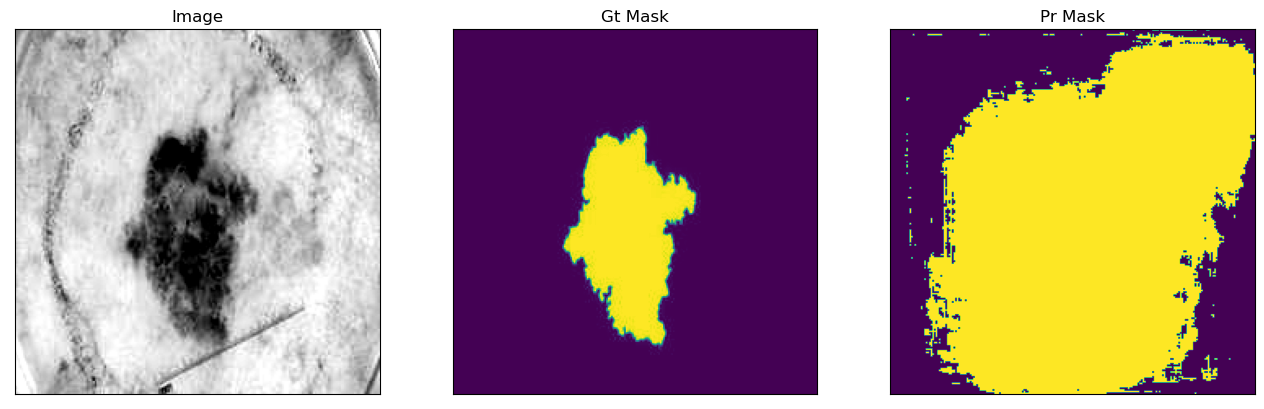

1/1 [==============================] - 0s 284ms/step


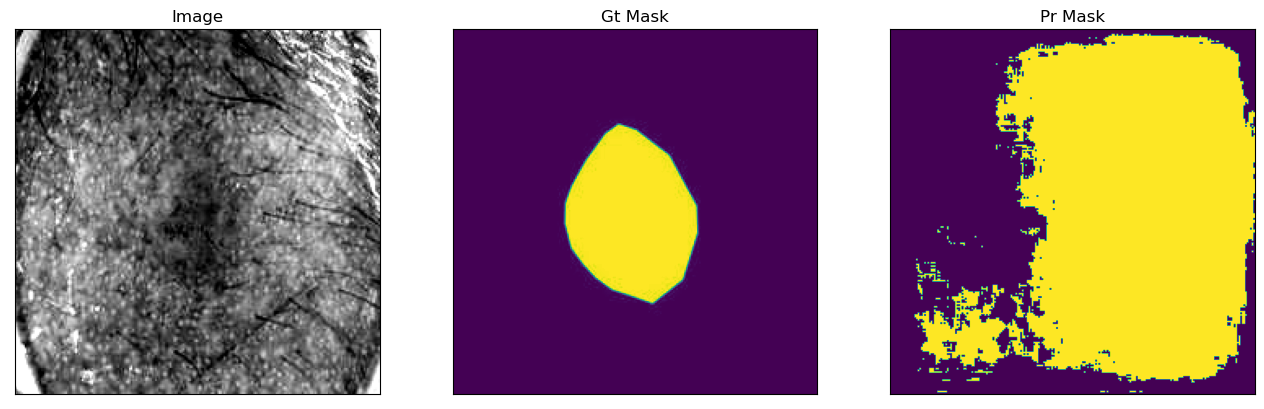

1/1 [==============================] - 0s 371ms/step


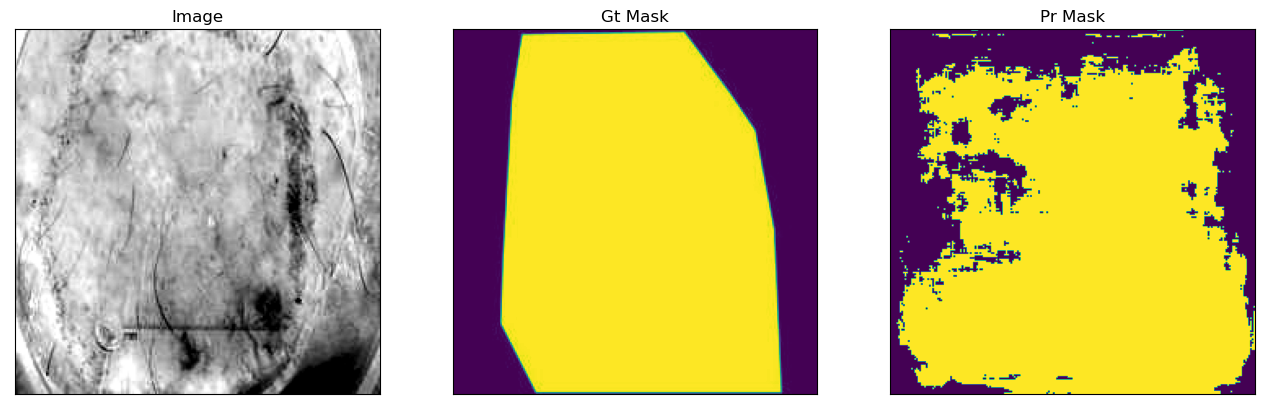

1/1 [==============================] - 0s 239ms/step


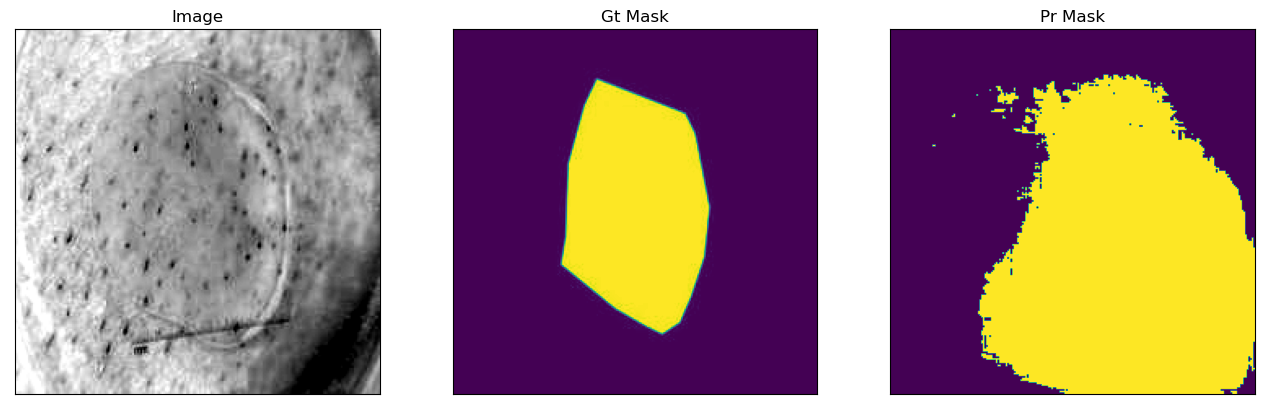

1/1 [==============================] - 0s 330ms/step


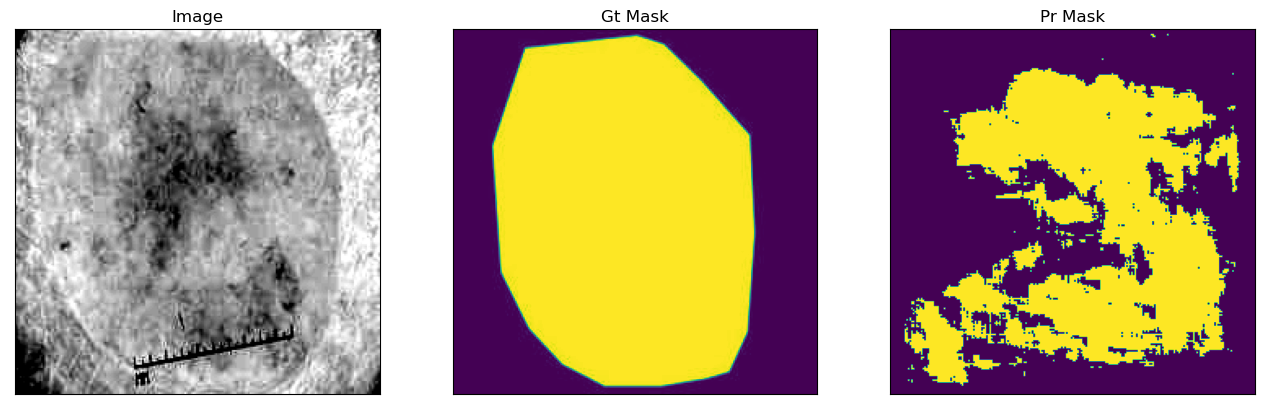

1/1 [==============================] - 0s 318ms/step


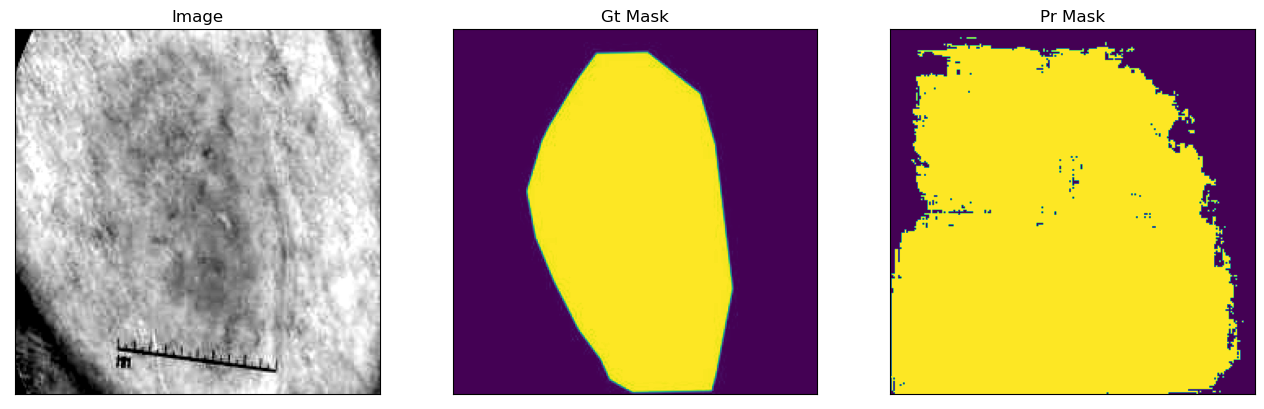

1/1 [==============================] - 0s 303ms/step


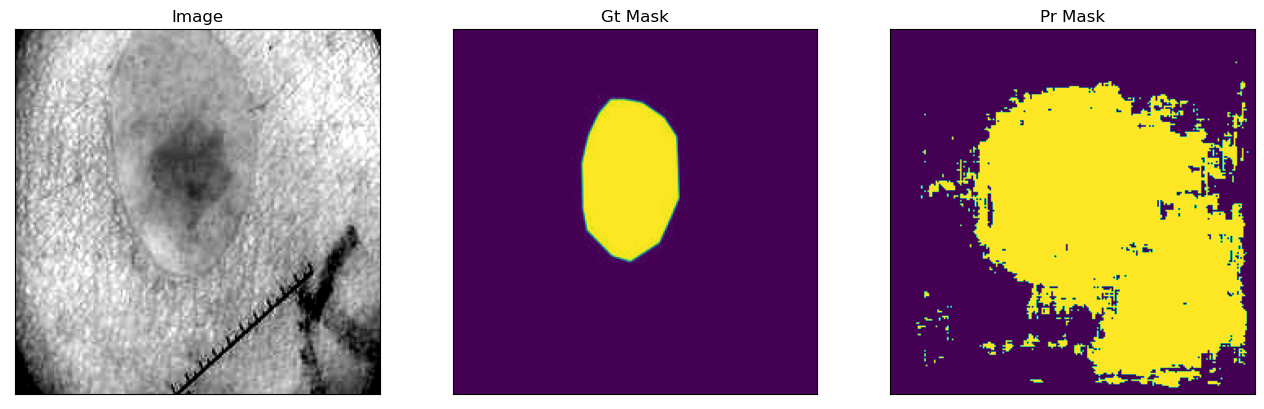

1/1 [==============================] - 0s 241ms/step


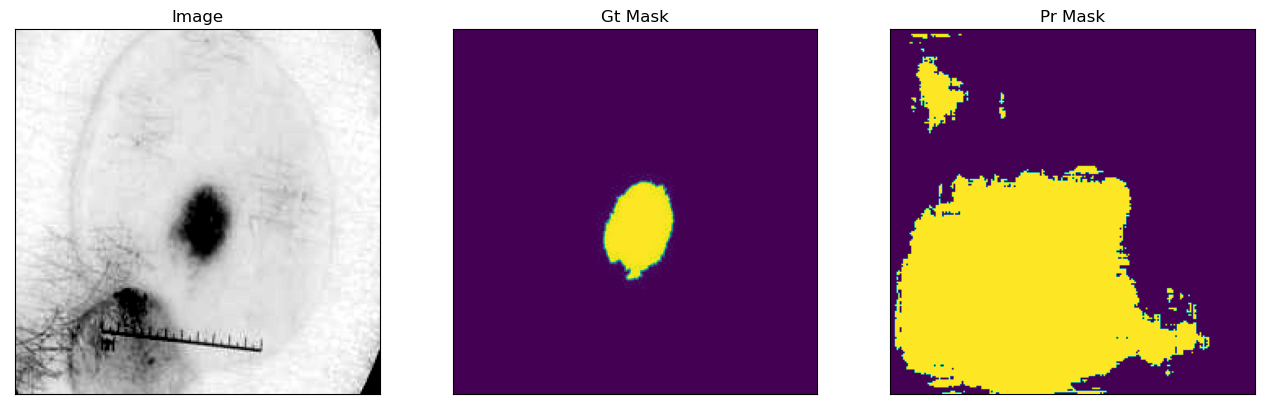

1/1 [==============================] - 0s 274ms/step


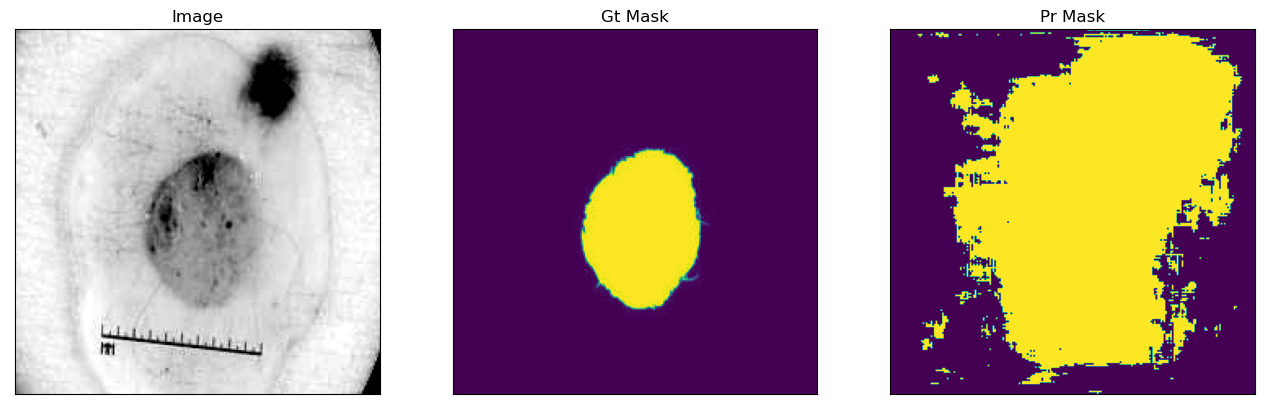

1/1 [==============================] - 0s 349ms/step


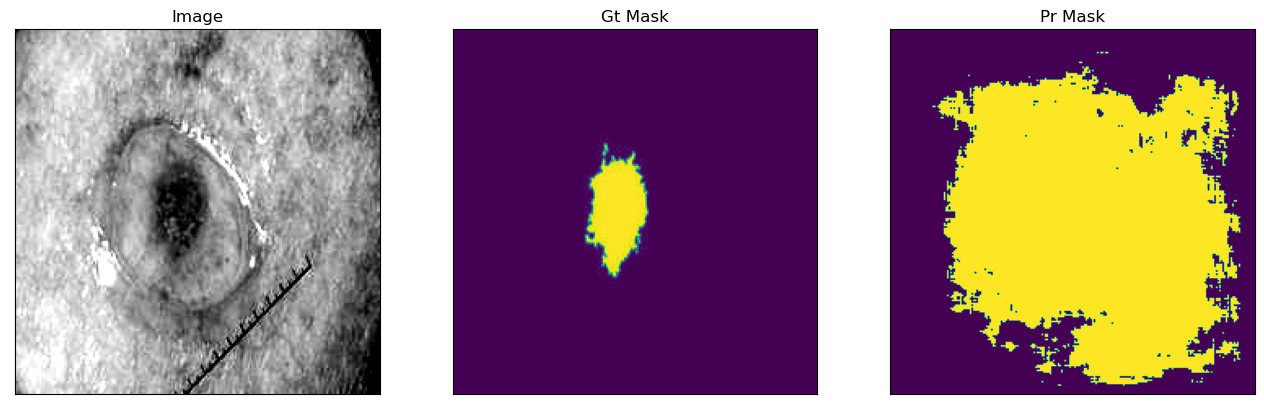

In [11]:
ct = 20
for batch in validation_dataset:
    image, gt_mask = batch
    image = image.numpy()
    gt_mask = gt_mask.numpy()
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )
    ct -= 1
    if ct == 0:
        break

In [ ]:
# Try changing backbone to resnet34 and resnet50
# Change batch_size and change learning_rate to 1e-05
# highest yet recorded was 58 with bce_jaccard loss - resnet34 - batch 16 - lr 1e-4 - grp=M
# Try densenet
# Try focal loss, dice_loss
# Try segnet
# Add more dropouts

In [ ]:
base_dir = '/media/dev/WinD/Curious Dev B/PROJECT STAGE - II/ISIC 2017 for segmentation (python)/'
train_dataset, validation_dataset = fetch(base_dir, input_size, grp)
scores = model.evaluate(train_dataset)

print('Evaluating on entire dataset...')
print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))